# Exercise 8

## Car Price Prediction

Predict if the price of a car is low or high

- Lupe Pinzon - 200813063
- Javier Lesmes - 200820243
- Viviana Muñoz - 201920081

In [6]:
%matplotlib inline
import pandas as pd

data = pd.read_csv('../datasets/dataTrain_carListings.zip')
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
15,2016,29242,0,0,0,0,1,0,0,1
47,2015,26465,0,0,0,0,1,0,0,1
85,2012,46739,0,1,0,0,0,0,0,1
141,2017,41722,0,0,0,0,0,1,0,1
226,2014,77669,0,0,0,0,0,0,1,0


In [7]:
data.shape

(13150, 10)

In [8]:
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.shape

(8810, 9)

# Exercise 8.1

Estimate a Decision Tree Classifier Manually using the code created in the Notebook #5 (Manual)

Evaluate the accuracy on the testing set

### Gini Impurity

In [17]:
import numpy as np
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [18]:
def gini_impurity(X_col, y, split):
    "Calculate the gain of an split k on feature j"
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y_train)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

### Splits 

In [19]:
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, ganancia
    
    # Para cada caracteristica
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada split
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

### Función recursiva

In [20]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si es solo una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular el mejor split
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    # Chequeo de parada
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree

    
    # Crear nueva partición
    
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [21]:
tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=3, num_pct=10)

### Predicciones

In [22]:
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Validar si es el ultimomo nodo
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # If left node is empty only continue with right
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  # If right node is empty only continue with left
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted    

In [23]:
predictions = tree_predict(X_test, tree)

In [24]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, predictions))

0.8610599078341014


# Exercise 8.2

Estimate a Bagging of 10 Decision Tree Classifiers Manually using the code created in the Notebook #7

Evaluate the accuracy on the testing set

In [25]:
np.random.seed(123)

n_samples = X_train.shape[0]
n_B = 10

# crear bootstrap samples
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]


#Crear arboles
predictions1 = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

for i in range(n_B):
    tree[i] = tree_grow(X_train.iloc[samples[i]], y_train.iloc[samples[i]], level=0, min_gain=0.001, max_depth=3, num_pct=10)
    predictions1.iloc[:, i] = tree_predict(X_test, tree[i])

#Accurancy de cada arbol
for i in range(n_B):
    print(i, accuracy_score(predictions1[i], y_test))

0 0.8670506912442396
1 0.8670506912442396
2 0.866589861751152
3 0.8642857142857143
4 0.8599078341013825
5 0.8610599078341014
6 0.8691244239631336
7 0.866589861751152
8 0.8668202764976959
9 0.8668202764976959


In [26]:
result= accuracy_score( predictions1.mean(axis=1).astype(np.int),y_test)
result

0.8624423963133641

# Exercise 8.3

Implement the variable max_features on the Decision Tree Classifier created in 11.1.

Compare the impact in the results by varing the parameter max_features

Evaluate the accuracy on the testing set

In [33]:
def tree_grow2(X, y, level=0, min_gain=0.001, max_depth=None, max_features=None, num_pct=10):
    
    # Si es solo una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Seleccionar aleatoria de las variables
    feat=np.random.choice(a=len(X.columns), size=max_features, replace=False)
    feat.sort()
    X = X.iloc[:,feat]
    
    # Calcular el mejor split
    j, split, gain = best_split (X, y, num_pct)
    
    # Guardar el árbol y estimar predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    # Chequeo de parada
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree
    
  
    # Crear nueva partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Next iteration to each split
    
    tree['sl'] = tree_grow2(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth,max_features=max_features,num_pct=num_pct)
    tree['sr'] = tree_grow2(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth,max_features=max_features,num_pct=num_pct)
    
    return tree

In [34]:
new_tree = tree_grow2(X_train, y_train, level=0, min_gain=0.001, max_depth=3, max_features=9, num_pct=10)

In [35]:
predictions2 = tree_predict(X_test, new_tree)

In [36]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, predictions2))

0.8610599078341014


In [37]:
df = pd.DataFrame(columns=['max_features','Accuracy'])
mf = range(0,10)

for i in mf:
    tree = tree_grow2(X_train, y_train, level=0, min_gain=0.001, max_depth=3, max_features=i,num_pct=10)
    y_pred = pd.DataFrame(tree_predict(X_test, tree))
    df.loc[i] = [i,accuracy_score(y_test, y_pred)]
    
df

,max_features,Accuracy
0,0.0,0.582488
1,1.0,0.582488
2,2.0,0.582488
3,3.0,0.861060
4,4.0,0.271659
5,5.0,0.861060
6,6.0,0.849770
7,7.0,0.861060
8,8.0,0.839862
9,9.0,0.861060


# Exercise 8.4

Estimate a Bagging of 10 Decision Tree Classifiers with `max_features = log(n_features)`

Evaluate the accuracy on the testing set

In [39]:
n_samples = X_train.shape[0]
n_B = 10

# crear bootstrap samples
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]


#Crear arboles
n_features = len(X.columns)
predictions = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

for i in range(n_B):
    new_tree[i] = tree_grow2(X_train.iloc[samples[i]], y_train.iloc[samples[i]], level=0, min_gain=0.001, max_depth=3, max_features=int(np.log(n_features)), num_pct=10)
    predictions.iloc[:, i] = tree_predict(X_test, new_tree[i])

#Accurancy de cada arbol
for i in range(n_B):
    print(i, accuracy_score(predictions[i], y_test))

0 0.5824884792626728
1 0.8594470046082949
2 0.5824884792626728
3 0.8495391705069124
4 0.8495391705069124
5 0.5824884792626728
6 0.5824884792626728
7 0.5824884792626728
8 0.866589861751152
9 0.8495391705069124


In [40]:
result= accuracy_score(predictions.mean(axis=1).astype(np.int),y_test)
result

0.8728110599078341

# Exercise 8.5

Using sklearn, train a RandomForestClassifier

Evaluate the accuracy on the testing set

In [41]:
from sklearn.ensemble import RandomForestClassifier

#Modelo
clf = RandomForestClassifier(n_estimators=10)

#Predicciones
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


In [42]:
#Accurancy
accuracy_score(y_pred, y_test)

0.843778801843318

# Exercise 8.6

Find the best parameters of the RandomForestClassifier (max_depth, max_features, n_estimators)

Evaluate the accuracy on the testing set

In [43]:
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt

### max_depth

Text(0, 0.5, 'Accuracy')

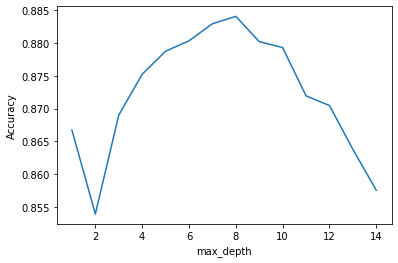

In [46]:
maxdepth_range = range(1,15)
accuracy_scores = []

for md in maxdepth_range:
    clf = RandomForestClassifier(n_estimators=10,max_depth=md,random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf,X_train, y_train, cv=5, scoring='accuracy').mean())
    
plt.plot(maxdepth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

De la grafica podemos concluir que el mejora parametro de max_depth es 8

### max_features

Text(0, 0.5, 'Accuracy')

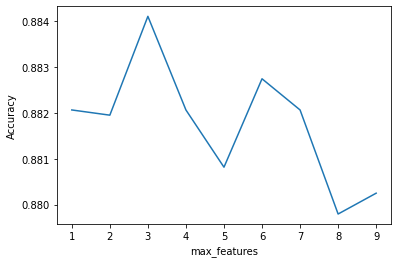

In [47]:
maxfeatures_range = range(1,10)
accuracy_scores = []

for mf in maxfeatures_range:
    clf = RandomForestClassifier(n_estimators=10, max_depth=8,max_features=mf,random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf,X_train, y_train, cv=5, scoring='accuracy').mean())
    
plt.plot(maxfeatures_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

De la grafica podemos concluir que el mejor max_features es 3

### n_estimators

Text(0, 0.5, 'Accuracy')

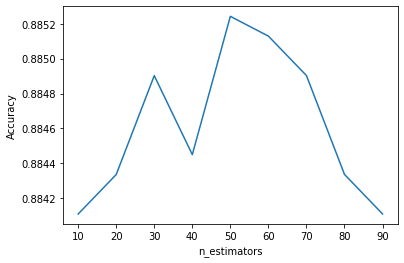

In [49]:
estimator_range = range(10,100,10)
accuracy_scores = []

for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=estimator, max_depth=8,max_features=3,random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())
    
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

De la grafica concluimos que el mejor n_estimators es 50

### Random Forest

In [159]:
clf = RandomForestClassifier(n_estimators=50, max_depth=8,max_features=3,random_state=1, n_jobs=-1)
cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean()

0.8852434957452285

Usando los mejores parametros encontrados, el accurancy pasa de 0,843 a 0,885

# Exercise 8.7 

Using xgboost train a XGBClassifier 

Evaluate the accuracy on the testing set

In [50]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

clf = XGBClassifier()

clf.fit(X_train, y_train)
y_pred2 = clf.predict(X_test)
accuracy_score(y_pred2, y_test.values)

0.8790322580645161

Usando XGBClassifier tebemos un un accurancy de 0,879 que supera la primera versión de Random Forest 0,843 pero aun esta por debajo de accurancy optenido con el Ramdom Forest usando los parametros hallados en el 8.6

# Exercise 8.8

Using xgboost train a XGBClassifier 

Modify the parameters learning rate, gamma, colsample_bytree. Explain what each parameter means.

Evaluate the accuracy on the testing set

### Learning Rate: 
Se usa para evitar el overfitting, es un factor de ponderación para las correcciones, que reducen los pesos de las variables para los nuevos árboles cuando se van agregan al modelo y tener un modelo mas conservador.

In [51]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

label_encoded_y = LabelEncoder().fit_transform(y_train)

clf2 = XGBClassifier()    
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(learning_rate=learning_rate)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
busqueda = GridSearchCV(clf2, param_grid, n_jobs=-1, cv=kfold)
resultado = busqueda.fit(X_train, label_encoded_y)

# summarize results
print("Best: %f using %s" % (resultado.best_score_, resultado.best_params_))

Best: 0.882860 using {'learning_rate': 0.1}


### Gamma
Entre mas grande gamma el modelo es mas conservador. Gamma especifica la reducción de pérdida mínima requerida para hacer una división.

In [52]:
gamma={
 'gamma':[i/10.0 for i in range(4,10)]
}
gamma

{'gamma': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

In [53]:
clf2 = XGBClassifier(eta=0.1) 
gamma={
 'gamma':[i/10.0 for i in range(0,5)]
}
param_grid = gamma
busqueda2 = GridSearchCV(clf2, param_grid, n_jobs=-1, cv=10)
resultado2 = busqueda2.fit(X_train,label_encoded_y)

# summarize results
print("Best: %f using %s" % (resultado2.best_score_, resultado2.best_params_))

Best: 0.884449 using {'gamma': 0.1}


### colsample_bytree

Es la proporción de submuestra de columnas al construir cada árbol.

In [54]:
clf2 = XGBClassifier(eta=0.1, gamma=0) 
colsample_bytree= {
 'colsample_bytree':[i/10.0 for i in range(4,10)]
}
param_grid = colsample_bytree
busqueda3 = GridSearchCV(clf2, param_grid, n_jobs=-1, cv=kfold)
resultado3 = busqueda3.fit(X_train,label_encoded_y)

# summarize results
print("Best: %f using %s" % (resultado3.best_score_, resultado3.best_params_))

Best: 0.884449 using {'colsample_bytree': 0.5}


In [55]:
clf2 = XGBClassifier(eta=0.1, gamma=0, colsample_bytree=0.5)

clf2.fit(X_train, y_train)
y_pred3 = clf2.predict(X_test)
accuracy_score(y_pred3, y_test.values)

0.8817972350230415

Al ajustar el modelo con los parametros tenemos un accurancy de 0,881 que supera el accurancy inicial de  0,879